In [ ]:
%%javascript

window.load_remote_theme = true
var theme_js = "https://odhk.github.io/hyrule_theme/custom.js";

window.load_local_theme = function(){
    var hostname = document.location.hostname
    return ((hostname == "localhost" || hostname == '127.0.0.1') && !load_remote_theme)
}

var url = load_local_theme() ? document.location.origin + "/files/theme/custom.js" : theme_js

$.getScript(url)

In [20]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as c
import theano.tensor as tt
from theano import shared
import pandas as pd
from scipy.special import gamma
from theano.compile.ops import as_op
# 数据导入
# companies：代表统一产品的测试地点类别    company：测试地点的搜索索引   
# companiesABC：代表不同公司类别           companyABC：公司的搜索索引
# ======================================================================

In [21]:
elec_data = pd.read_csv('XZmulti_6.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()#  
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code']= elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values
print(company)
print(companies_num)

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values
print(company_ABC)
print(companyABC)
print(companiesABC)

[0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 5 5 5 5 5 6
 6 6 6 6 6 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 5
 5 5 5 5 6 6 6 6 6 6 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4
 4 4 4 5 5 5 5 5 5 6 6 6 6 6 6]
[1 2 3 4 5 6 7]
['A' 'B' 'C']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
3


In [22]:
# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
elec_tem = elec_data.Tem.values  # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values  # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大1000倍以增加实际效果，结果中要缩小1000倍
# elec_fault = elec_data.Fault / elec_data.Nums
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式
elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)
# print(elec_year )
print(elec_faults[0:3])
print()

[ 0.01017501  0.01017501  0.02035002]



In [23]:
# 共享变量设置
train_year = elec_year
train_abc = companyABC
train_faults = elec_faults

test_year = elec_year
test_abc = companyABC
# test_faults = elec_faults[-2:]

x_shared = shared(np.asarray(train_year))
# x_shared1 = shared(elec_tem[:-2])
Num_shared = shared(np.asarray(train_abc))
y_shared = shared(np.asarray(train_faults))
# print(train_year)
print(train_faults)
# print(len(train_faults))

[  1.01750102e-02   1.01750102e-02   2.03500204e-02   4.68050468e-01
   1.71957672e+00   5.90150590e-01   0.00000000e+00   2.09205021e-01
   2.09205021e-01   2.09205021e-01   2.51046025e+00   2.09205021e+00
   6.02845430e-03   6.02845430e-03   1.20569086e-02   5.18447070e-01
   1.14540632e-01   3.01422715e-02   1.52508769e-01   3.81271923e-01
   0.00000000e+00   3.50770169e-01   4.11773677e-01   2.28763154e-01
   3.97456280e-02   7.94912560e-02   4.76947536e-01   1.19236884e+00
   8.34658188e-01   7.94912560e-02   8.93655049e-02   8.93655049e-02
   1.78731010e-01   2.68096515e-01   3.30652368e+00   3.39588919e+00
   3.63108206e-02   1.08932462e-01   0.00000000e+00   3.41321714e+00
   3.84894699e+00   2.90486565e+00   3.38933264e-03   6.35499870e-02
   6.49622089e-02   1.14954865e-01   1.35290861e-01   1.64382633e-01
   1.29545425e-03   1.03636340e-02   4.79318073e-02   6.08863498e-02
   4.53408988e-02   1.37318151e-01   3.12861746e-03   2.50289397e-02
   1.12630229e-01   4.06720270e-02

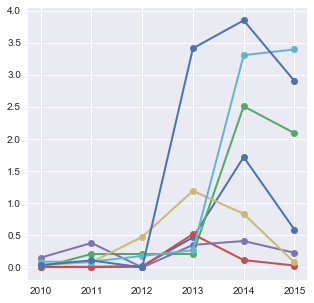

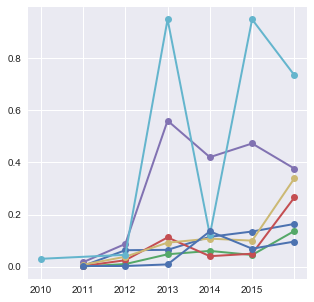

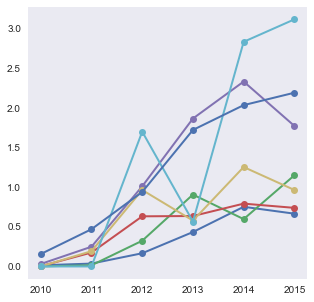

In [24]:
j, Num = 0, 6
fig=plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
for m in range(7):
    ax1.plot(elec_year[j:(j+Num)], elec_faults[j:(j+Num)], 'o-', linewidth=2)
    j = j+6
ax1.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'])
fig2=plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111)       
for m in range(7):
    ax2.plot(elec_year[j:(j+Num)], elec_faults[j:(j+Num)],'o-', linewidth=2)
    j = j+6
ax2.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'])
fig3=plt.figure(figsize=(5,5))
ax3 = fig3.add_subplot(111)
for m in range(7):
    ax3.plot(elec_year[j:(j+Num)], elec_faults[j:(j+Num)],'o-', linewidth=2)
    j = j+6  
ax3.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'])
plt.grid()
plt.show()
# ax=plt.subplot()
# xData=np.arange(0,200,1)
# yData1=elec_faults[1]
# plt.figure(num=1, figsize=(8, 6))
# # plt.title('Plot 1', size=14)
# # plt.xlabel('x-axis', size=14)
# # plt.ylabel('y-axis', size=14)
# plt.plot(xData, yData1, color='b', linestyle='--', marker='o', label='y1 data')
# # plt.plot(xData, yData2, color='r', linestyle='-', label='y2 data')
# plt.legend(loc='upper left')
# plt.show()

In [7]:
# elec_year1[0:84] = 7
# plt.style.use('default')
# plt.hist(elec_faults, range=[0, 5], bins=130, histtype='stepfilled', color='#6495ED')
# plt.axvline(elec_faults.mean(), color='r', ls='--', label='True mean')
# plt.show()
print(companiesABC)

3


In [8]:
def invlogit(x):
    return tt.exp(x)/(tt.exp(x)+1)

In [11]:
with pm.Model() as unpooled_model:

#     scale = pm.Gamma('scale', alpha=1, beta=1)
    alpha1 = pm.Normal('alpha1', 0, 1000)
    beta1=pm.Normal('beta1', 0, 1000)
#     alpha1=pm.Exponential('alpha1',1.0/scale)
    theta=pm.Normal('theta', mu=0, sd=beta1, shape=companiesABC)
    lambda1=pm.Deterministic('lambda1',tt.exp(theta[Num_shared] * elec_year))
    
#     beta = pm.Normal('beta', 0, 100)
    psi = invlogit(lambda1)
    Observed=pm.ZeroInflatedPoisson("Observed",psi =psi, theta=alpha1 , observed=train_faults)
#     start = pm.findMAP()
#     step=pm.NUTS()
    
    trace2 = pm.sample(5000)
#     'advi+adapt_diag'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
  2%|▋                                      | 91/5500 [00:00<00:05, 909.97it/s]


ValueError: Bad initial energy: nan. The model might be misspecified.

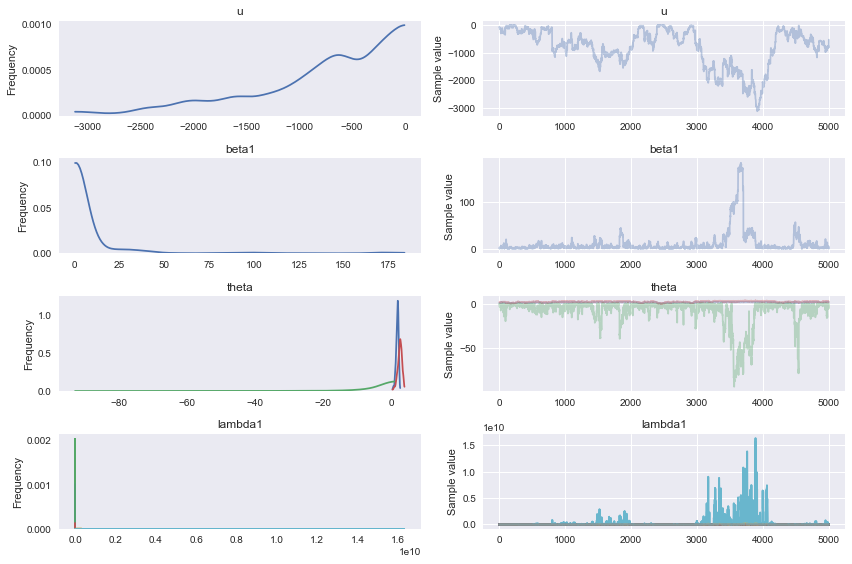

In [10]:
pm.traceplot(trace2)
plt.show()

In [ ]:
# with pm.Model() as unpooled_model:

#     scale = pm.Gamma('scale', alpha=1, beta=1)
#     beta1=pm.Gamma('beta1', alpha=1, beta=1)
#     alpha1=pm.Exponential('alpha1',1.0/scale)
#     theta=pm.Gamma('theta', alpha=alpha1, beta=beta1,shape=companiesABC)
#     lambda1=pm.Deterministic('lambda1',tt.exp(theta[Num_shared] * elec_year))
    
#     Observed=pm.Poisson("Observed",mu=lambda1,observed=train_faults)
    ##方法一
#      alpha = pm.Gamma('alpha', alpha=1, beta=1)
#      scale = pm.Gamma('scale', alpha=1, beta=1)

#      a = pm.Gamma('a', alpha=alpha, beta=1.0/scale)
#      Observed=pm.Poisson("Observed",mu=a,observed=train_faults)
        
#      trace2 = pm.sample(2000)  
  ## 方法二
    # define priors
#     alpha = pm.HalfCauchy('alpha', 10)
    
#     switch = pm.DiscreteUniform('switch', lower=x_shared.min()+3, upper=x_shared.max()-0.5)
#     early_rate = pm.Normal('early_rate', 0, 100)
#     late_rate = pm.Normal('late_rate', 0, 100)     
#     beta1 = pm.math.switch(x_shared <= switch, early_rate, late_rate)

#     beta1 = pm.Normal('beta1', 0, 1000, shape=companiesABC)
#     beta_mu = pm.Normal('beta_mu', 0, 1000)
#     beta_sd = pm.HalfNormal('beta_sd', sd=10)
    
#     alpha_tp_mu=pm.Normal('alpha_tp_mu',mu=0,sd=100)
#     alpha_tp_sd=pm.Normal('alpha_tp_sd',mu=0,sd=100)
#     alpha=pm.Normal('alpha',mu=0,sd=100)
    
#     beta=pm.Normal('beta',mu=beta_mu,sd=beta_sd,shape=companiesABC)
#     alpha_tp=pm.Normal('alpha_tp',mu=alpha_tp_mu,sd=alpha_tp_sd,shape=companiesABC)
#     u = pm.Normal('u', 0, 100)
    
#     nu = pm.Exponential('nu', 1/30)
#     x = np.linspace(0, 6,210 )
#     mu = tt.exp(beta[companyABC] + beta1[companyABC]*elec_year + beta2*elec_tem)
#     alpha = pm.Gamma('alpha', alpha=1, beta=1)
#     scale = pm.Gamma('scale', alpha=1, beta=1)
   ##方法三
#     a = pm.Gamma('a', alpha=alpha, beta=1.0/scale, shape=Num_shared)
#     intercept = pm.Normal('Intercept', 0, sd=1000)
#     slope = pm.Normal('Slope', 0, sd=20,shape=companiesABC)
#     sigma = pm.HalfCauchy('sigma', beta=10)
#     likelihood = pm.Normal('train_faults', mu=intercept + slope[Num_shared] * elec_year, sd=sigma, observed=train_faults)
#     beta_d = pm.Deterministic('beta_d', tt.exp(beta[Num_shared]+alpha_tp[Num_shared]))
#     beta_d=pm.Deterministic('beta_d',tt.exp(intercept + slope[Num_shared] * elec_year))
    # Observed_pred = pm.Weibull("Observed_pred",  alpha=mu, beta=sigma, shape=elec_faults.shape)  # 观测值
#     Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_d, observed=train_faults)  # 观测值
#     Observed=pm.Poisson("Observed",mu=a,observed=train_faults)

    # step = pm.Slice([beta1, u])
#     trace2 = pm.sample(2000)

In [ ]:
# chain2 = trace2[1000:]
# # varnames1 = ['alpha', 'beta_mu', 'swich']
# # print(pm.df_summary(trace2, varnames1))
# # varnames2 = ['beta', 'early_rate', 'late_rate', 'alpha', 'u']
# # pm.plot_posterior(chain2, varnames2, ref_val=0)
# pm.traceplot(chain2)
# plt.show()

In [ ]:
# 两种能量图
energy = trace2['energy']
energy_diff = np.diff(energy)
sns.distplot(energy - energy.mean(), label='energy')
sns.distplot(energy_diff, label='energy diff')
plt.legend()
plt.show()
pm.energyplot(trace2)
plt.show()
map_estimate = pm.find_MAP(model=unpooled_model)
print(map_estimate)
# 画出自相关曲线
pm.autocorrplot(chain2, varnames2)
plt.show()
print(pm.waic(trace2, unpooled_model))